## <span style='font-family:Georgia'> Objectives
The purpose of this notebook is to modeling training process overview \& evaluation of the model's performance on the test set

*Authors: Elżbieta Jowik, Agata Kaczmarek, Agata Makarewicz*

In [51]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.metrics import precision_recall_fscore_support, f1_score
from typing import List, Tuple

import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

plt.style.use("bmh")
plt.rcParams.update({
    "figure.figsize" : (6.5, 6.5),
    "axes.facecolor" : "white",
    "axes.edgecolor":  "black"
    })

In [52]:
def convert_to_array(matrix: str):
    array = []
    for l in matrix[1:-1].split('\r\n'):
        lst = [
            int(i.replace(']', '')) for i in l.split() if i.replace(']', '').isdigit()
            ]
        array.append(lst)
    return np.array(array)

In [53]:
def extract_baseline_prediction(pred_file_path: str, exp_file_path: str, labels = [":", ";", ",", ".", "-", "?", "!"]) -> Tuple[List[str]]:
    """ Extracts prediction from text output """
    
    # Load & prepare evaluation data
    data_test = pd.read_csv(pred_file_path)
    data_expected = pd.read_csv(exp_file_path)

    data_test.columns=['FileId', 'baseline']
    data_expected.columns=['FileId', 'expected']
    data_test_joined = data_expected.merge(data_test, left_on='FileId', right_on='FileId')

    # Split rows for evaluation
    test_last_char=[]
    exp_last_char=[]
    for i in range(len(data_test_joined)):
        splitted_test_first=data_test_joined.loc[i, 'baseline'].split(' ')
        splitted_exp_first=data_test_joined.loc[i, 'expected'].split(' ')
        for j in range(min(len(splitted_test_first), len(splitted_exp_first))):
            test_last_char.append(splitted_test_first[j][-1])
            exp_last_char.append(splitted_exp_first[j][-1])

    # Assign labels
    y_true = [x if x in labels else 'B' for x in exp_last_char]
    y_pred = [x if x in labels else 'B' for x in test_last_char]
    
    return y_true, y_pred


def extract_ner_prediction(pred_file_path: str, exp_file_path: str, labels = [":", ";", ",", ".", "-", "?", "!"]):
    data_model= pd.read_csv(pred_file_path, sep='\t', header=None)
    data_exp_model=pd.read_csv(exp_file_path, sep='\t', header=None)

    data_model.columns=['model']
    data_exp_model.columns=['expected']

    data_exp_model['expected'] = data_exp_model['expected'] .apply(lambda x: x.replace(' "', '"'))
    data_exp_model['expected'] = data_exp_model['expected'] .apply(lambda x: x.replace('  ', ' '))

    # for whole dataset
    model_last_char=[]
    model_exp_last_char=[]

    for i in range(len(data_exp_model)):
        splitted_model_first=data_model['model'][i].split(' ')
        splitted_model_exp_first=data_exp_model['expected'][i].split(' ')
        for j in range(min(len(splitted_model_first), len(splitted_model_exp_first))):
            model_last_char.append(splitted_model_first[j][-1])
            model_exp_last_char.append(splitted_model_exp_first[j][-1])

    y_true = [x if x in labels[1:] else 'B' for x in model_exp_last_char]
    y_pred = [x if x in labels[1:] else 'B' for x in model_last_char]
    
    return y_true, y_pred


def evaluate_model(y_true:List, y_pred:List, include_blanks:bool, labels:List=["B", ":", ";", ",", ".", "-", "?", "!"]) -> Tuple[pd.DataFrame, float]:
    """
    Generates summary and calculates weighted F1 score
    """
    
    summary=pd.DataFrame(
        precision_recall_fscore_support(
            y_true,
            y_pred,
            labels = labels
        )
    ).T

    summary.columns = ["precision", "recall", "f1-score", "support"]
    summary.index = labels

    if include_blanks:
        summary['weights'] = summary['support']/summary['support'].sum()
        f1_weighted = f1_score(y_true, y_pred, average='weighted')

    else:
        summary['weights'] = np.where(summary.index.isin(labels[1:]), summary['support'], 0)
        summary['weights'] = summary['weights']/summary['weights'].sum()
        f1_weighted = (summary['weights'] * summary['f1-score']).sum()
    
    return summary, f1_weighted

### <span style='font-family:Georgia'> Section 1.: Training progress overview

In [3]:
results = pd.read_csv('../data/outputs/modeling_pipeline/step6/training_progress_scores.csv')

#### <span style='font-family:Georgia'> The course of the cost function in the learning process

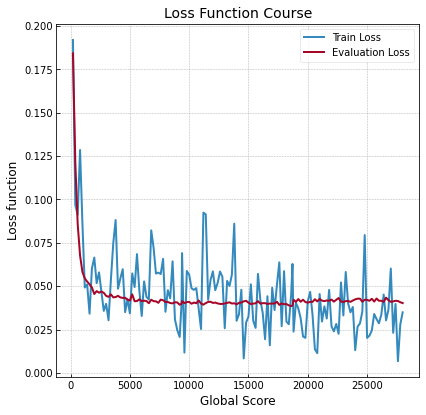

In [4]:
plt.title("Loss Function Course", fontsize=14)
plt.plot(results['global_step'], results['train_loss'], label='Train Loss')
plt.plot(results['global_step'], results['eval_loss'], label='Evaluation Loss')
plt.xlabel("Global Score", fontsize=12)
plt.ylabel("Loss function", fontsize=12)
plt.legend()
plt.show()

#### <span style='font-family:Georgia'> The courses of the Precision, Recall & Weighted F1 scores in the learning process

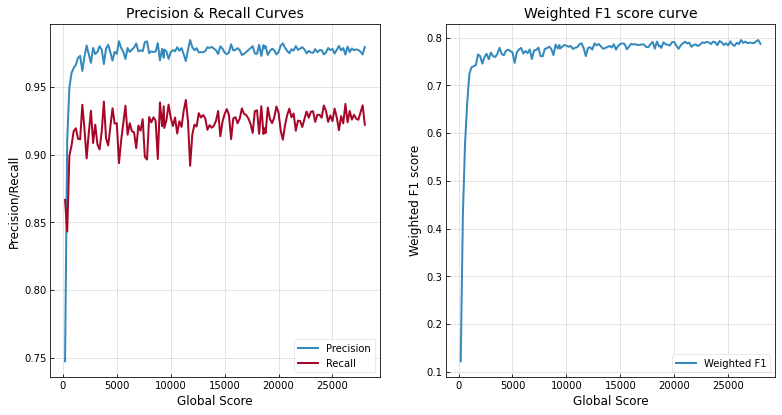

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6.5))

axes[0].set_title("Precision & Recall Curves", fontsize=14)
axes[0].plot(results['global_step'], results['precision'], label='Precision')
axes[0].plot(results['global_step'], results['recall'], label='Recall')
axes[0].set_xlabel("Global Score", fontsize=12)
axes[0].set_ylabel("Precision/Recall", fontsize=12)
axes[0].legend()

axes[1].set_title("Weighted F1 score curve", fontsize=14)
axes[1].plot(results['global_step'], results['f1_weighted'], label='Weighted F1')
axes[1].set_xlabel("Global Score", fontsize=12)
axes[1].set_ylabel("Weighted F1 score", fontsize=12)
axes[1].legend()

#### <span style='font-family:Georgia'> Comparison of confusion matrix at different stages of the learning process

In [6]:
labels = ["B", ":", ";", ",", ".", "-", "?", "!"]

init_conf_matr = results.iloc[results.index.min(), -4]
result_conf_matr = results.iloc[results.index.max(), -4]

init_conf_matr = convert_to_array(init_conf_matr)
result_conf_matr = convert_to_array(result_conf_matr)

display(
    Markdown(
        "#### <span style='font-family:Georgia'> Confusion matrix at the beginning of the learning process"
    )
)
display(pd.DataFrame(init_conf_matr, columns=labels[1:], index=labels[1:]))

display(
    Markdown(
        "#### <span style='font-family:Georgia'> Confusion matrix at the end of the learning process"
    )
)
display(pd.DataFrame(result_conf_matr, columns=labels[1:], index=labels[1:]))

#### <span style='font-family:Georgia'> Confusion matrix at the beginning of the learning process

,:,;,",",.,-,?,!
:,0,0,43,131,0,0,0
;,0,0,0,0,0,0,0
",",0,0,787,1543,0,0,0
.,0,0,668,2025,0,0,0
-,0,0,199,412,0,0,0
?,0,0,46,157,0,0,0
!,0,0,9,26,0,0,0


#### <span style='font-family:Georgia'> Confusion matrix at the end of the learning process

,:,;,",",.,-,?,!
:,621,0,33,95,53,2,0
;,0,0,0,0,0,0,0
",",22,0,8549,523,149,46,17
.,20,0,289,9761,51,38,14
-,45,0,313,273,1520,26,2
?,4,0,28,127,8,539,2
!,2,0,16,49,2,11,22


### <span style='font-family:Georgia'> Section 2.: Model evaluation

### <span style='font-family:Georgia'> 2.1 Baseline with pauses evaluation

In [54]:
y_true, y_pred = extract_baseline_prediction(
    pred_file_path='../data/outputs/baseline/including_pauses/test_data.csv',
    exp_file_path='../data/outputs/feature_engineering/data_cleaning/test/test_exp_with_ids_clean.csv'
)

#### <span style='font-family:Georgia'> 2.1.1 Including blanks

In [55]:
summary, f1_weighted = evaluate_model(y_true=y_true, y_pred=y_pred, include_blanks=True)

In [56]:
summary

,precision,recall,f1-score,support,weights
B,0.939333,0.890054,0.914030,33853.0,0.845775
:,0.000000,0.000000,0.000000,322.0,0.008045
;,0.000000,0.000000,0.000000,0.0,0.000000
",",0.579770,0.282226,0.379645,2498.0,0.062409
.,0.302094,0.792056,0.437372,2568.0,0.064158
-,0.000000,0.000000,0.000000,621.0,0.015515
?,0.000000,0.000000,0.000000,144.0,0.003598
!,0.000000,0.000000,0.000000,20.0,0.000500


In [57]:
f1_weighted

0.8248184425436056

#### <span style='font-family:Georgia'> 2.1.2 Excluding blanks

In [58]:
summary, f1_weighted = evaluate_model(y_true=y_true, y_pred=y_pred, include_blanks=False)

In [59]:
summary

,precision,recall,f1-score,support,weights
B,0.939333,0.890054,0.914030,33853.0,0.000000
:,0.000000,0.000000,0.000000,322.0,0.052163
;,0.000000,0.000000,0.000000,0.0,0.000000
",",0.579770,0.282226,0.379645,2498.0,0.404665
.,0.302094,0.792056,0.437372,2568.0,0.416005
-,0.000000,0.000000,0.000000,621.0,0.100599
?,0.000000,0.000000,0.000000,144.0,0.023327
!,0.000000,0.000000,0.000000,20.0,0.003240


In [60]:
f1_weighted

0.33557821366690577

### <span style='font-family:Georgia'> 2.2 Baseline without pauses evaluation

In [62]:
y_true, y_pred = extract_baseline_prediction(
    pred_file_path='../data/outputs/baseline/excluding_pauses/test_data.csv',
    exp_file_path='../data/outputs/feature_engineering/data_cleaning/test/test_exp_with_ids_clean.csv'
)

#### <span style='font-family:Georgia'> 2.2.1 Including blanks

In [63]:
summary, f1_weighted = evaluate_model(y_true=y_true, y_pred=y_pred, include_blanks=True)

In [64]:
summary

,precision,recall,f1-score,support,weights
B,0.857109,0.971060,0.910533,33863.0,0.845729
:,0.000000,0.000000,0.000000,322.0,0.008042
;,0.000000,0.000000,0.000000,0.0,0.000000
",",0.418296,0.214171,0.283294,2498.0,0.062388
.,0.103535,0.015953,0.027647,2570.0,0.064186
-,0.000000,0.000000,0.000000,621.0,0.015509
?,0.000000,0.000000,0.000000,146.0,0.003646
!,0.000000,0.000000,0.000000,20.0,0.000500


In [65]:
f1_weighted

0.7895132092722028

#### <span style='font-family:Georgia'> 2.2.2 Excluding blanks

In [66]:
summary, f1_weighted = evaluate_model(y_true=y_true, y_pred=y_pred, include_blanks=False)

In [67]:
summary

,precision,recall,f1-score,support,weights
B,0.857109,0.971060,0.910533,33863.0,0.000000
:,0.000000,0.000000,0.000000,322.0,0.052129
;,0.000000,0.000000,0.000000,0.0,0.000000
",",0.418296,0.214171,0.283294,2498.0,0.404403
.,0.103535,0.015953,0.027647,2570.0,0.416060
-,0.000000,0.000000,0.000000,621.0,0.100534
?,0.000000,0.000000,0.000000,146.0,0.023636
!,0.000000,0.000000,0.000000,20.0,0.003238


In [41]:
f1_weighted

0.12606757045944916

### <span style='font-family:Georgia'> 2.3 Neural model evaluation

In [68]:
y_true, y_pred = extract_ner_prediction(
    pred_file_path='../data/outputs/modeling_pipeline/step7/test-A/out.tsv',
    exp_file_path='../data/source/test-A/expected.tsv'
)

#### <span style='font-family:Georgia'> 2.3.1 Including blanks

In [69]:
summary, f1_weighted = evaluate_model(y_true=y_true, y_pred=y_pred, include_blanks=True)

In [70]:
summary

,precision,recall,f1-score,support,weights
B,0.973181,0.953395,0.963186,34331.0,0.857332
:,0.000000,0.000000,0.000000,0.0,0.000000
;,0.000000,0.000000,0.000000,11.0,0.000275
",",0.668852,0.741818,0.703448,2475.0,0.061807
.,0.711876,0.861576,0.779605,2449.0,0.061158
-,0.645522,0.563518,0.601739,614.0,0.015333
?,0.721088,0.736111,0.728522,144.0,0.003596
!,0.263158,0.250000,0.256410,20.0,0.000499


In [71]:
f1_weighted

0.9289017476469329

#### <span style='font-family:Georgia'> 2.3.2 Excluding blanks

In [72]:
summary, f1_weighted = evaluate_model(y_true=y_true, y_pred=y_pred, include_blanks=False)

In [73]:
summary

,precision,recall,f1-score,support,weights
B,0.973181,0.953395,0.963186,34331.0,0.000000
:,0.000000,0.000000,0.000000,0.0,0.000000
;,0.000000,0.000000,0.000000,11.0,0.001925
",",0.668852,0.741818,0.703448,2475.0,0.433222
.,0.711876,0.861576,0.779605,2449.0,0.428671
-,0.645522,0.563518,0.601739,614.0,0.107474
?,0.721088,0.736111,0.728522,144.0,0.025206
!,0.263158,0.250000,0.256410,20.0,0.003501


In [74]:
f1_weighted

0.7228758151037834